In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
def binstr2array(arr_str, dtype=np.float64):
    arr_str = arr_str.encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
    return np.frombuffer(arr_str, dtype=dtype)

In [3]:
df = pd.read_csv("../reports/effective_lrs/v1.csv.zip")
df["loss"] = df["loss"].clip(upper=df["loss"].quantile(0.995))

In [4]:
df["schedule"] = df["schedule"].replace({"Exponential": "Exp.", "Exponential reset": "Exp. Reset"})
df["accuracy"] *= 100

In [5]:
dfm = agg_dataframe(df, cols_to_keep=["dataset", "optimizer", "step", 'schedule'])
dfm['schedule'] = dfm['schedule'].apply(lambda x: x.title())

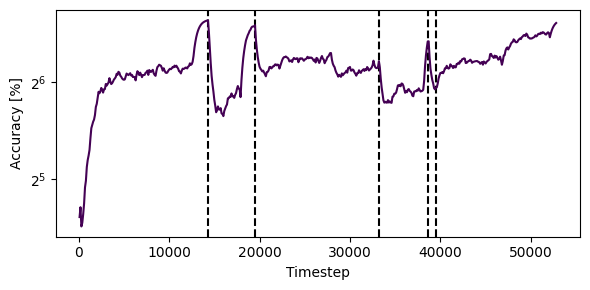

In [6]:
# Make Plot for Insects abrupt dataset
schedules = [
    # "Exp.",
    # "Exp. Reset",
    "Fixed",
]
base_schedules = [schedule.strip(" Reset") for schedule in schedules]

dfp = dfm[
    (dfm["dataset"] == "Insects abrupt")
    & (dfm["optimizer"] == "SGD")
    & (dfm["schedule"].isin(schedules))
]
change_points = [14352, 19500, 33240, 38682, 39510]
metrics = ["accuracy_mean"]
names = ["Accuracy [%]"]

cmapper = ValueColorMapper(values=schedules)
fig, axs = plt.subplots(nrows=1, figsize=(6, 3), sharex=True)
axs = [axs]
for row_idx, metric in enumerate(metrics):
    ax = axs[row_idx] 
    for change_point in change_points:
        ax.axvline(change_point, color="black", linestyle="dashed")
    for schedule, dfs in dfp.groupby("schedule"):
        base_schedule = schedule.strip(" Reset")
        color = cmapper(schedule)
        ax.plot(
            dfs["step"],
            dfs[metric].ewm(alpha=0.2).mean(),
            c=color,
            label=schedule,
        )

for ax, name in zip(axs, names):
    ax.set_ylabel(name)
ax.set_yscale("log", base=2)
# axs[1].legend()
ax.set_xlabel("Timestep")
fig.tight_layout()
plt.savefig("../pub/figures/sgd_insects_abrupt.pdf")

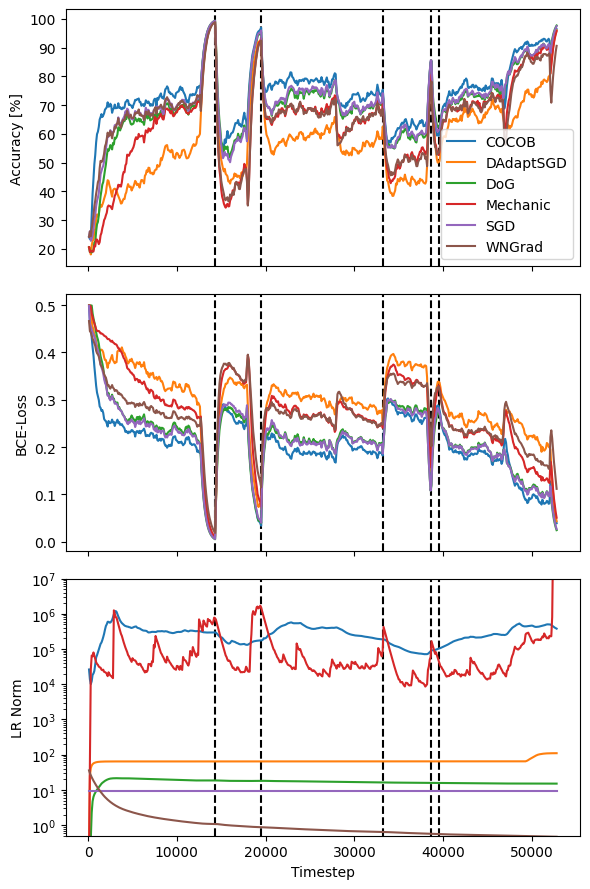

In [8]:
# Make Plot for Insects abrupt dataset
dfp = dfm.copy()
optims = dfp['optimizer'] + " " + dfp['schedule']
dfp['optimizer'] = optims.apply(lambda x: x.replace(' Fixed', ""))

optimizers = [
    "SGD",
    # "SGD Exp. Reset",
    "COCOB",
    "WNGrad",
    "DAdaptSGD",
    "DoG",
    # "AdaGrad",
    "Mechanic",
]

dfp = dfp[(dfp["dataset"] == "Insects abrupt") & (dfp["optimizer"].isin(optimizers))]
change_points = [14352, 19500, 33240, 38682, 39510]
metrics = ["accuracy_mean", "loss_mean", "lr_norm_mean"]
names = ["Accuracy [%]", "BCE-Loss", "LR Norm"]

cmapper = ValueColorMapper(values=dfp["optimizer"].unique())
fig, axs = plt.subplots(nrows=3, figsize=(6, 9), sharex=True)
for row_idx, metric in enumerate(metrics):
    ax = axs[row_idx]
    for change_point in change_points:
        ax.axvline(change_point, color="black", linestyle="dashed")
    for schedule, dfs in dfp.groupby("optimizer"):
        color = cmapper(schedule)
        ax.plot(
            dfs["step"],
            dfs[metric].ewm(alpha=0.2).mean(),
            # c=color,
            label=schedule,
        )

for ax, name in zip(axs, names):
    ax.set_ylabel(name)
ax.set_yscale("log")
ax.set_ylim([.5, 1e7])
axs[0].legend()
ax.set_xlabel("Timestep")
fig.tight_layout()
plt.savefig("../pub/figures/lr_norms_optims_insects_abrupt.pdf")